In [2]:
#@title Import Libraries
from google.colab import drive,files
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import re
import unicodedata
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics,linear_model
from sklearn.metrics import mean_squared_error,roc_curve, confusion_matrix
import altair as alt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [3]:
#@title Helper Functions
def get_tpr_fpr(df,prob):
  df['prediction']=np.where(df['Predicted_Prob']>=prob, 1, 0)
  tp=((df['prediction']==1) & (df['Survived']==1)).sum()
  tn=((df['prediction']==0) & (df['Survived']==0)).sum()
  fn=((df['prediction']==0) & (df['Survived']==1)).sum()
  fp=((df['prediction']==1) & (df['Survived']==0)).sum()
  tpr=tp/(tp+fn)
  fpr=fp/(fp+tn)
  return tpr, fpr

def get_tp_tn_fp_fn_total(df,prob):
  df['prediction']=np.where(df['Predicted_Prob']>=prob, 1, 0)
  tp=((df['prediction']==1) & (df['Survived']==1)).sum()
  tn=((df['prediction']==0) & (df['Survived']==0)).sum()
  fn=((df['prediction']==0) & (df['Survived']==1)).sum()
  fp=((df['prediction']==1) & (df['Survived']==0)).sum()
  return tp, tn, fn, fp, len(df)

In [4]:
#@title Upload and read file
uploaded = files.upload()
titanic=pd.read_csv("titanic.csv")

Saving titanic.csv to titanic.csv


In [5]:
#@title Analysing the File
titanic.head()
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
#@title Factorize the independent variable
#sex
codes, uniques = pd.factorize(titanic['Sex'])
titanic['sex_code'] = codes

#cabin
codes, uniques = pd.factorize(titanic['Cabin'])
titanic['cabin_code'] = codes

#embarked
codes, uniques = pd.factorize(titanic['Embarked'])
titanic['embarked_code'] = codes

titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            714 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          204 non-null    object 
 11  Embarked       889 non-null    object 
 12  sex_code       891 non-null    int64  
 13  cabin_code     891 non-null    int64  
 14  embarked_code  891 non-null    int64  
dtypes: float64(2), int64(8), object(5)
memory usage: 104.5+ KB


In [7]:
#@title Test Train Split
# Complete cases of data
titanic_cc=titanic[['Pclass','sex_code','SibSp','Parch','Fare','embarked_code','Survived']]
#titanic_cc.dropna(axis = 0, how = 'any', inplace = True)

X=titanic_cc[['Pclass','sex_code','SibSp','Parch','Fare','embarked_code']]
Y=titanic_cc[['Survived']]
X.dtypes
# print(type(Y))
# print(type(X))
X_test, X_train, y_test, y_train=train_test_split(X,Y,test_size=0.8,
                                              random_state=22)

In [8]:
reg_model=linear_model.LogisticRegression()
reg_model.fit(X_train,y_train)
predictions=reg_model.predict(X_test)
y_pred = reg_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
y_true=y_test
accuracy_s = metrics.accuracy_score(y_true, y_pred)
accuracy_s

0.8539325842696629

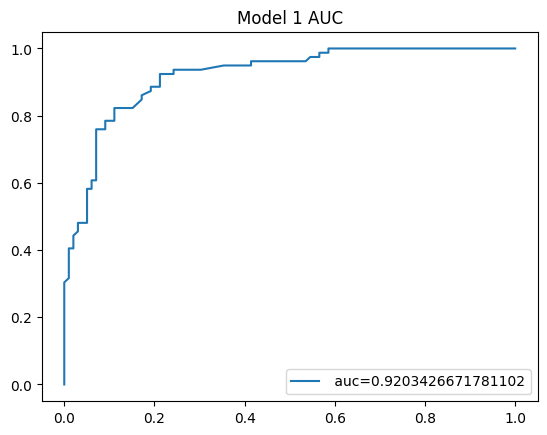

In [10]:
y_pred_proba = reg_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
## creating a DF
auc_arr = np.tile(auc, len(fpr))
model_arr=np.tile('Model 1', len(fpr))
data = np.column_stack((fpr, tpr,auc_arr,model_arr))
df = pd.DataFrame(data, columns=['fpr', 'tpr','auc','model'])
plt.plot(fpr,tpr,label=" auc="+str(auc))
plt.legend(loc=4)
plt.title('Model 1 AUC')
plt.show()

In [11]:
df

,fpr,tpr,auc,model
0,0.0,0.0,0.9203426671781102,Model 1
1,0.0,0.012658227848101266,0.9203426671781102,Model 1
2,0.0,0.26582278481012656,0.9203426671781102,Model 1
3,0.0,0.3037974683544304,0.9203426671781102,Model 1
4,0.010101010101010102,0.31645569620253167,0.9203426671781102,Model 1
5,0.010101010101010102,0.35443037974683544,0.9203426671781102,Model 1
6,0.010101010101010102,0.3924050632911392,0.9203426671781102,Model 1
7,0.010101010101010102,0.4050632911392405,0.9203426671781102,Model 1
8,0.020202020202020204,0.4050632911392405,0.9203426671781102,Model 1
9,0.020202020202020204,0.4430379746835443,0.9203426671781102,Model 1


In [12]:
#@title Evaluation on testing data
model1_eval=X_test.copy()
model1_eval['Predicted_Prob']=reg_model.predict_proba(X_test)[::,1]
model1_eval['Survived']=y_test
model1_eval.head()

,Pclass,sex_code,SibSp,Parch,Fare,embarked_code,Predicted_Prob,Survived
141,3,1,0,0,7.7500,0,0.567923,1
281,3,0,0,0,7.8542,0,0.113392,0
6,1,0,0,0,51.8625,0,0.413748,0
509,3,0,0,0,56.4958,0,0.126709,1
330,3,1,2,0,23.2500,2,0.612165,1


In [13]:
## Get FPR and TPR at Probability thresholds=0.65
tpr,fpr=get_tpr_fpr(model1_eval,prob=0.6)
print("TPR: "+str(tpr)+" FPR: "+str(fpr))

TPR: 0.6075949367088608 FPR: 0.06060606060606061


In [14]:
## Get FPR and TPR at Probability thresholds=0.7
tpr,fpr=get_tpr_fpr(model1_eval,prob=0.7)
print("TPR: "+str(tpr)+" FPR: "+str(fpr))

TPR: 0.4050632911392405 FPR: 0.010101010101010102


Text(0, 0.5, 'TPR')

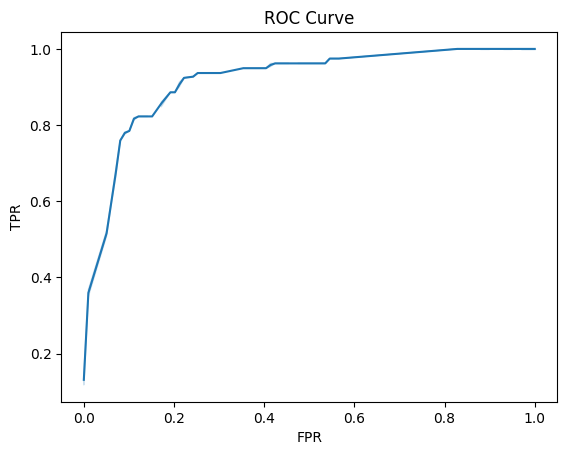

In [15]:
thresholds=list(range(0, 1000))
roc_df=pd.DataFrame(columns=['fpr', 'tpr','prob_threshold'])
for i in range(len(thresholds)):
  tpr,fpr=get_tpr_fpr(model1_eval,prob=thresholds[i]/1000)
  data = np.column_stack((fpr, tpr,thresholds[i]))
  df_temp = pd.DataFrame(data, columns=['fpr', 'tpr','prob_threshold'])
  roc_df = pd.concat([roc_df, df_temp], ignore_index=True)
sns.lineplot(data=roc_df,x='fpr',y='tpr')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [16]:
#@title Manually Calculating AUC
# we create pools of probabilies of positive and negative outcomes and randomly select each observation from both the pools. Later we count % of times probabily of a positive example was > probability of negative example. By definition this should
# equal AUC
positive_pool=model1_eval.query('Survived==1')['Predicted_Prob']
negative_pool=model1_eval.query('Survived==0')['Predicted_Prob']

In [17]:
cnt=0
i=0
while(i<100000):
  p=positive_pool.sample(1).iloc[0]
  n=negative_pool.sample(1).iloc[0]
  if(p>n):
    cnt+=1
  i+=1
print("Manually Calculated AUC: "+str(round((cnt/100000),3)))

Manually Calculated AUC: 0.92


In [24]:
df_sample=model1_eval.sample(n=70)
alt.Chart(model1_eval,title="Predicted Probabilities").mark_circle(size=80,opacity=0.5).encode(
    alt.X('Predicted_Prob:Q'),
    color='Survived:N'
).properties(
    width=900,
    height=50
)

alt.Chart(...)

Altair Charts are not renderred in Github. So adding the result of above code as PNG 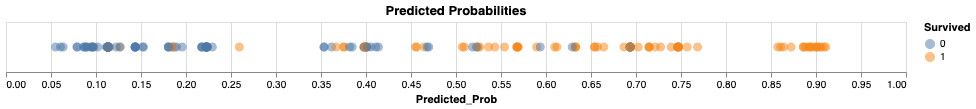